# **Hello Pycaret**

## **Librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from datetime import datetime, timedelta
import winsound

In [4]:
from pycaret.classification import *

## **Datos**

### **Exploración Inicial**

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv')

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df['TotalCharges'].replace(' ', np.nan, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [9]:
df.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3474,3982-DQLUS,Male,1,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,85.75,5688.45,No


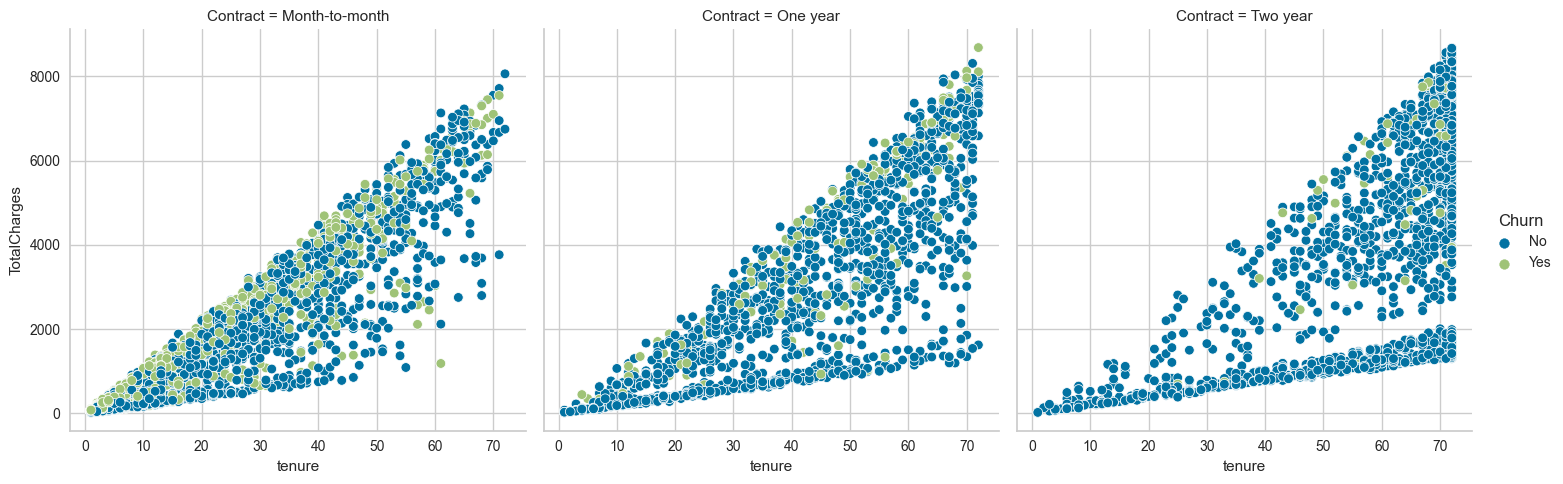

In [10]:
sns.relplot(
   	data=df, 
    x='tenure', 
    y='TotalCharges', 
    col='Contract',
    hue='Churn'
)

plt.show()

### **Preparación de los Datos**

In [11]:
setup = setup(
    df,
    target = 'Churn',
    ignore_features=['customerID']
)

,Description,Value
0,session_id,8122
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


### **Entrenamiento del Modelo**

In [12]:
%%time
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8012,0.8459,0.5358,0.6706,0.5945,0.4652,0.4711,0.6520
lr,Logistic Regression,0.8051,0.8417,0.5686,0.6678,0.6135,0.4844,0.4877,1.2510
ada,Ada Boost Classifier,0.7996,0.8417,0.5335,0.6663,0.5920,0.4613,0.4668,0.2680
lda,Linear Discriminant Analysis,0.7980,0.8354,0.5693,0.6477,0.6052,0.4704,0.4726,0.0370
lightgbm,Light Gradient Boosting Machine,0.7972,0.8340,0.5455,0.6552,0.5939,0.4605,0.4648,0.1250
nb,Naive Bayes,0.7379,0.8287,0.7929,0.5128,0.6225,0.4358,0.4604,0.0190
rf,Random Forest Classifier,0.7882,0.8210,0.4993,0.6467,0.5622,0.4257,0.4328,0.5560
et,Extra Trees Classifier,0.7730,0.7912,0.4792,0.6063,0.5345,0.3873,0.3925,0.5370
knn,K Neighbors Classifier,0.7499,0.7338,0.4338,0.5507,0.4834,0.3224,0.3271,0.0630
dt,Decision Tree Classifier,0.7237,0.6558,0.5030,0.4945,0.4981,0.3077,0.3082,0.0360


CPU times: total: 7.33 s
Wall time: 43.5 s


In [13]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8122, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### **Ajuste de HiperParametros**

In [14]:
%%time
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8154,0.8717,0.5630,0.7037,0.6255,0.5050,0.5106
1,0.7708,0.7830,0.4815,0.6019,0.5350,0.3854,0.3896
2,0.8276,0.8777,0.5746,0.7333,0.6444,0.5328,0.5397
3,0.7870,0.8378,0.5970,0.6107,0.6038,0.4582,0.4582
4,0.8337,0.8815,0.5522,0.7708,0.6435,0.5388,0.5516
5,0.7789,0.8243,0.4478,0.6316,0.5240,0.3854,0.3951
6,0.7951,0.8502,0.5075,0.6602,0.5738,0.4420,0.4486
7,0.8032,0.8552,0.5746,0.6581,0.6135,0.4824,0.4844
8,0.7809,0.8324,0.5299,0.6121,0.5680,0.4223,0.4242


CPU times: total: 2.92 s
Wall time: 1min 34s


### **Análisis del Modelo**

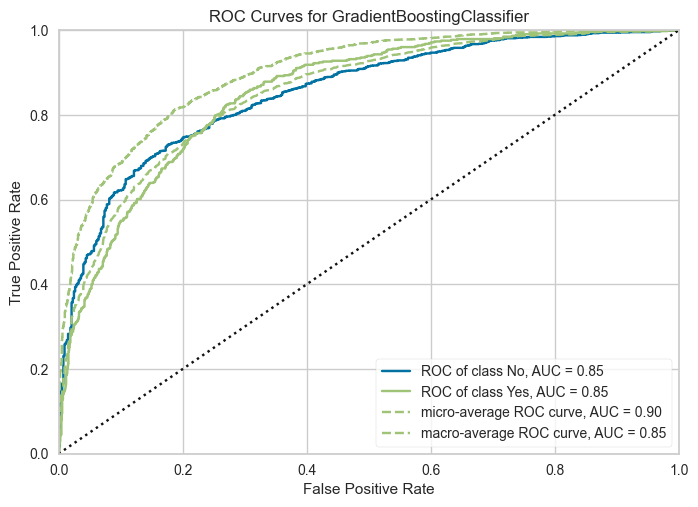

In [15]:
plot_model(tuned_best_model, plot='auc')

#### **Feature Importance**

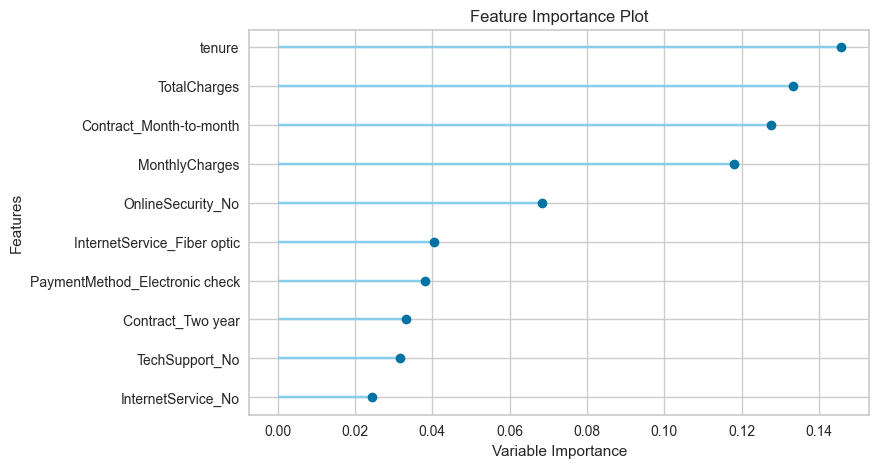

In [16]:
plot_model(tuned_best_model, plot='feature')

#### **Matriz de Confusión**

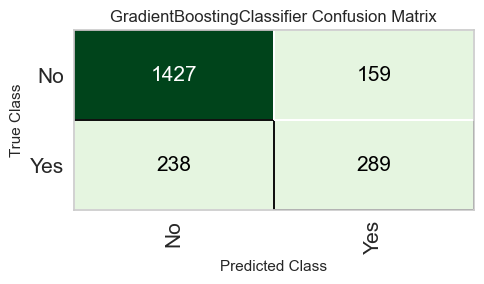

In [17]:
plt.subplots(figsize = (5, 3))
plot_model(tuned_best_model, plot='confusion_matrix')

In [18]:
# La ganancia por usuario es de 5000. Descontamos el costo de la retención (1000)
retenidos = (288 * 4000) 
# Cómo son usuarios que se van perdemos el costo de la retención (1000)
churn = (158 * -1000)

In [19]:
# El valor de nuestra ganancia es igual a
print(retenidos + churn)

994000


### **Agregando una métrica personalizada al modelo**

In [20]:
def calculate_profit(y, y_pred):
    tp = np.where((y_pred == 1) & (y == 1), (5000 - 1000), 0) 
    fp = np.where((y_pred == 1) & (y == 0), (0 - 1000), 0) 
    
    return np.sum([tp, fp])

In [21]:
add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <function calculate_profit at 0x000001CB14B35C10>
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [22]:
new_best_model = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.7379,0.8287,0.7929,0.5128,0.6225,0.4358,0.4604,324200.0000,0.0210
lr,Logistic Regression,0.8051,0.8417,0.5686,0.6678,0.6135,0.4844,0.4877,267000.0000,0.1530
lda,Linear Discriminant Analysis,0.7980,0.8354,0.5693,0.6477,0.6052,0.4704,0.4726,263800.0000,0.0410
lightgbm,Light Gradient Boosting Machine,0.7972,0.8340,0.5455,0.6552,0.5939,0.4605,0.4648,253800.0000,0.1230
gbc,Gradient Boosting Classifier,0.8012,0.8459,0.5358,0.6706,0.5945,0.4652,0.4711,251900.0000,0.6260
ada,Ada Boost Classifier,0.7996,0.8417,0.5335,0.6663,0.5920,0.4613,0.4668,250200.0000,0.2590
ridge,Ridge Classifier,0.7990,0.0000,0.5298,0.6643,0.5887,0.4582,0.4637,248400.0000,0.0220
rf,Random Forest Classifier,0.7882,0.8210,0.4993,0.6467,0.5622,0.4257,0.4328,230800.0000,0.5140
qda,Quadratic Discriminant Analysis,0.6335,0.6446,0.6691,0.4098,0.4971,0.2426,0.2685,222900.0000,0.0320
et,Extra Trees Classifier,0.7730,0.7912,0.4792,0.6063,0.5345,0.3873,0.3925,215200.0000,0.5140


#### **Matriz de Confusión**

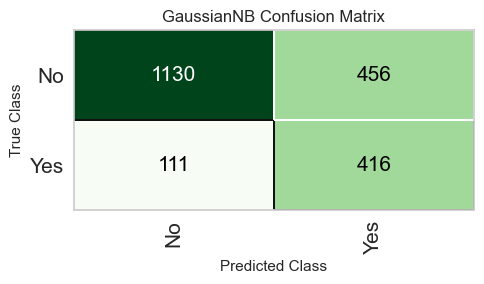

In [23]:
plt.subplots(figsize = (5, 3))
plot_model(new_best_model, plot='confusion_matrix')

In [24]:
# La ganancia por usuario es de 5000. Descontamos el costo de la retención (1000)
retenidos = (419 * 4000) 
# Cómo son usuarios que se van perdemos el costo de la retención (1000)
churn = (406 * -1000)

In [25]:
# El valor de nuestra ganancia es igual a
print(retenidos + churn)

1270000
